In [16]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import math
from prettytable import PrettyTable
from scipy import sparse
import csv
import graphviz

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, make_scorer
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from wordcloud import WordCloud
from sklearn.cluster import KMeans

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [2]:
%%time
data_train = pd.read_csv('./Matrices/data_train.csv')
data_test = pd.read_csv('./Matrices/data_test.csv')
data = pd.concat([data_train, data_test], ignore_index=True)

del data_train, data_test

Wall time: 1.02 s


# BOW based K-Means Clustering

In [3]:
def run_kmeans(data, vects):
    sc = StandardScaler()
    
    data_np = data.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Score', 'Summary', 'Text', 'CleanedText'], axis=1)
    data_np = np.hstack((data_np, vects))
    data_np = sc.fit_transform(data_np)
    
    errors = []; clusters = [2, 5, 7, 8, 10];
    for i in clusters:
        print(f'Starting Cluster #{i}')
        model = KMeans(n_clusters=i, random_state=42, verbose=0)
        model.fit(data_np)
        errors.append(model.inertia_)
    
    plt.plot(clusters, errors)
    plt.xlabel('Clusters')
    plt.ylabel('Errors')
    plt.show()
    
    return data_np

In [4]:
%%time
cv_model = CountVectorizer(max_features=1000, min_df=10)
bow_counts = cv_model.fit_transform(data['CleanedText'].values)
print(bow_counts.shape)

(80000, 1000)
Wall time: 2.79 s


Starting Cluster #2
Starting Cluster #5
Starting Cluster #7
Starting Cluster #8
Starting Cluster #10


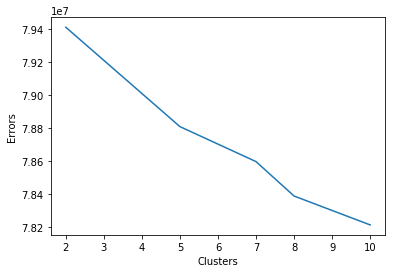

Wall time: 15min 57s


In [5]:
%%time
data_np = run_kmeans(data, bow_counts.toarray())

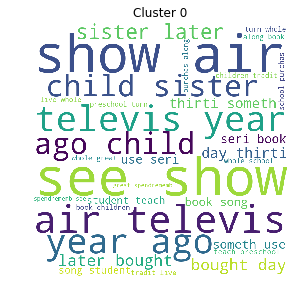

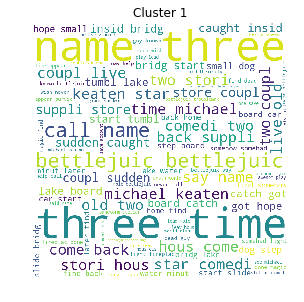

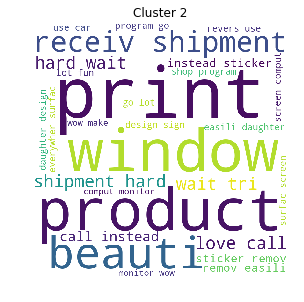

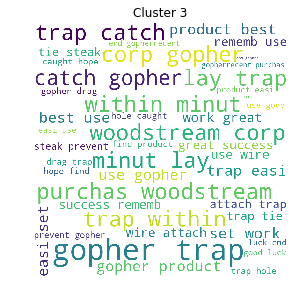

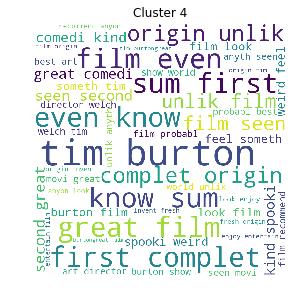

Wall time: 14min 42s


In [6]:
%%time
model = KMeans(n_clusters=5, random_state=42, verbose=0)
model.fit(data_np)
cluster_sets = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}
cluster_reviews = dict()
for i in cluster_sets:
    for j in cluster_sets[i]:
        cluster_reviews[i] = cluster_reviews.get(i, '') + data.iloc[i]['CleanedText']
        
for i in range(model.n_clusters):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10).generate(cluster_reviews[i])

    # plot the WordCloud image
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title(f'Cluster {i}')
    plt.tight_layout(pad = 0)

plt.show()

# TFIDF based K-Means Clustering

In [7]:
%%time
tfidf_model = TfidfVectorizer(max_features=1000, min_df=10)
vectors = tfidf_model.fit_transform(data['CleanedText'].values)
print(vectors.shape)

(80000, 1000)
Wall time: 3.14 s


Starting Cluster #2
Starting Cluster #5
Starting Cluster #7
Starting Cluster #8
Starting Cluster #10


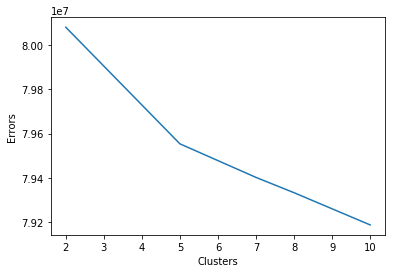

Wall time: 21min 58s


In [8]:
%%time
data_np = run_kmeans(data, vectors.toarray())

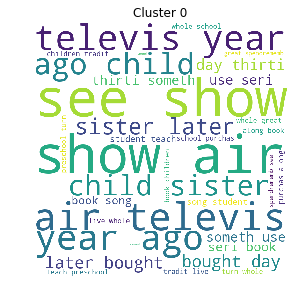

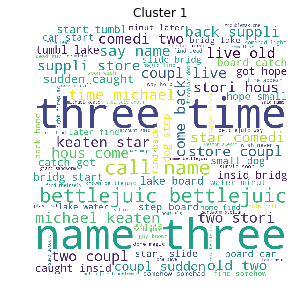

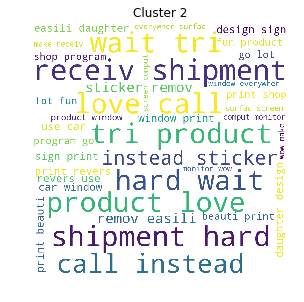

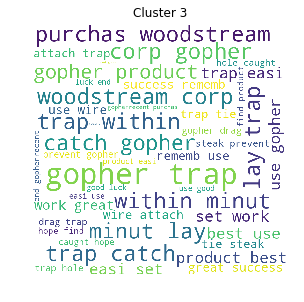

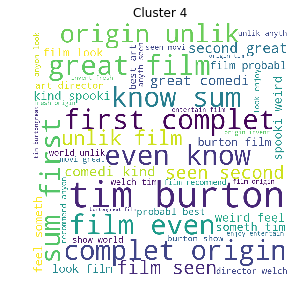

Wall time: 9min


In [9]:
%%time
model = KMeans(n_clusters=5, random_state=42, verbose=0)
model.fit(data_np)
cluster_sets = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}
cluster_reviews = dict()
for i in cluster_sets:
    for j in cluster_sets[i]:
        cluster_reviews[i] = cluster_reviews.get(i, '') + data.iloc[i]['CleanedText']

for i in range(model.n_clusters):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10).generate(cluster_reviews[i])

    # plot the WordCloud image
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title(f'Cluster {i}')
    plt.tight_layout(pad = 0)

plt.show()

# Avg. W2V based K-Means Clustering

In [10]:
%%time
sent_vectors_train = pd.read_csv('./Matrices/avg_w2v_train.csv')
sent_vectors_test = pd.read_csv('./Matrices/avg_w2v_test.csv')
vectors = pd.concat([sent_vectors_train, sent_vectors_test], ignore_index=True)

Wall time: 1.64 s


Starting Cluster #2
Starting Cluster #5
Starting Cluster #7
Starting Cluster #8
Starting Cluster #10


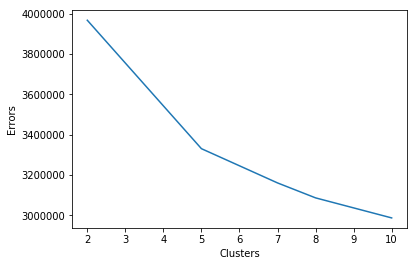

Wall time: 1min 25s


In [11]:
%%time
data_np = run_kmeans(data, vectors)

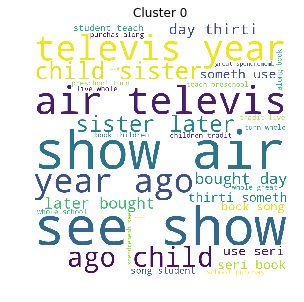

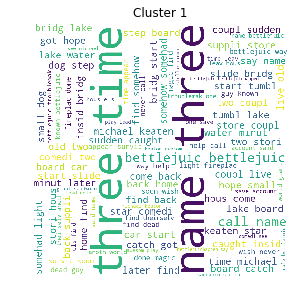

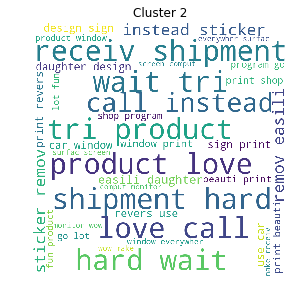

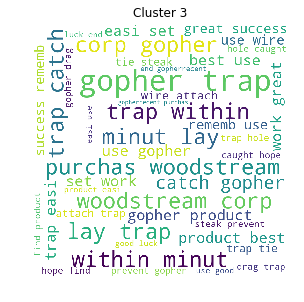

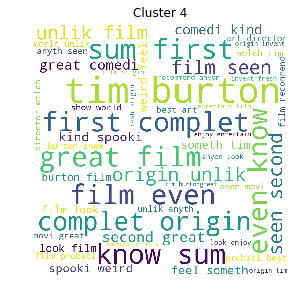

Wall time: 3min 4s


In [12]:
%%time
model = KMeans(n_clusters=5, random_state=42, verbose=0)
model.fit(data_np)
cluster_sets = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}
cluster_reviews = dict()
for i in cluster_sets:
    for j in cluster_sets[i]:
        cluster_reviews[i] = cluster_reviews.get(i, '') + data.iloc[i]['CleanedText']

for i in range(model.n_clusters):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10).generate(cluster_reviews[i])

    # plot the WordCloud image
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title(f'Cluster {i}')
    plt.tight_layout(pad = 0)

plt.show()

# TFIDF-weighted W2V based K-Means Clustering

In [13]:
%%time
sent_vectors_train = pd.read_csv('./Matrices/tfidf_w2v_train.csv')
sent_vectors_test = pd.read_csv('./Matrices/tfidf_w2v_test.csv')
vectors = pd.concat([sent_vectors_train, sent_vectors_test], ignore_index=True)

Wall time: 1.61 s


Starting Cluster #2
Starting Cluster #5
Starting Cluster #7
Starting Cluster #8
Starting Cluster #10


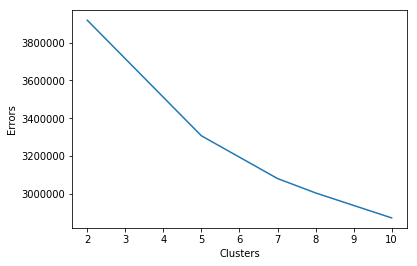

Wall time: 57.4 s


In [14]:
%%time
data_np = run_kmeans(data, vectors)

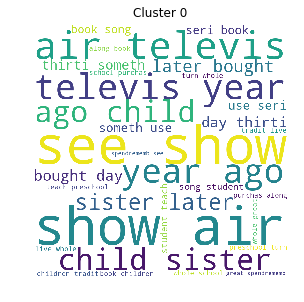

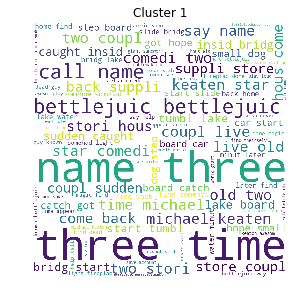

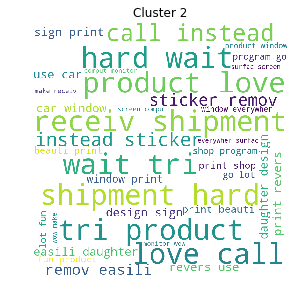

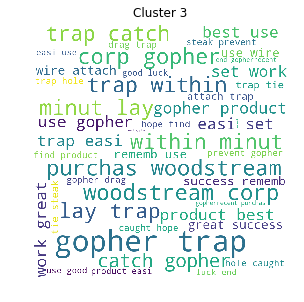

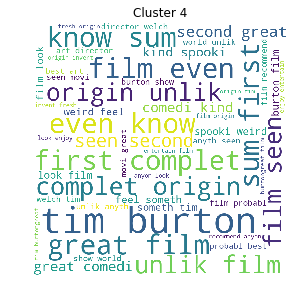

Wall time: 2min 51s


In [15]:
%%time
model = KMeans(n_clusters=5, random_state=42, verbose=0)
model.fit(data_np)
cluster_sets = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}
cluster_reviews = dict()
for i in cluster_sets:
    for j in cluster_sets[i]:
        cluster_reviews[i] = cluster_reviews.get(i, '') + data.iloc[i]['CleanedText']

for i in range(model.n_clusters):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10).generate(cluster_reviews[i])

    # plot the WordCloud image
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title(f'Cluster {i}')
    plt.tight_layout(pad = 0)

plt.show()

## Summary :-
- The Dataset is imported and various Vectorizer models are trained on the pre-processed Amazon Food Reviews.
- The data is then Standardized and fed to KMeans Clustering with a number of 'K' values.
- The Optimal 'K' is evaluated using the Elbow method using 'Clusters' vs 'Inertia' and a final Clustering is performed using the optimal 'K'.
- Cluster Sets are evaluated such that each cluster number contains all the words from all Reviews in that Cluster.
- Word Cloud is used to highlight the words present in each of the Clusters.